In [1]:
%matplotlib inline

In [2]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import gymnasium as gym

from envs.createEnvs import createNNEnv
from utilities.plots import create_dicts_Qlearning, create_grids, plot_string_policy

In [3]:
env = createNNEnv()

Loading models...
Models loaded


In [4]:
# reset the environment to get the first observation
done = False
observation, _ = env.reset()

print(f'Initial observation: {observation}')

Initial observation: [4 0]


In [5]:
action = env.action_space.sample()

# execute the action in the environment and receive info
observation, reward, terminated, _, _ = env.step(action)

print(observation)


[4 0]


In [6]:
class GridWorldNNAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [7]:
# hyperparameters
learning_rate = 0.02
n_episodes = 50000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = GridWorldNNAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [8]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

for episode in tqdm(range(n_episodes)):
    obs, _ = env.reset()
    obs = tuple(observation)

    done = False
    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, _, _ = env.step(action)
        next_obs = tuple(next_obs)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 50000/50000 [02:56<00:00, 283.06it/s]


## Visualizing the training




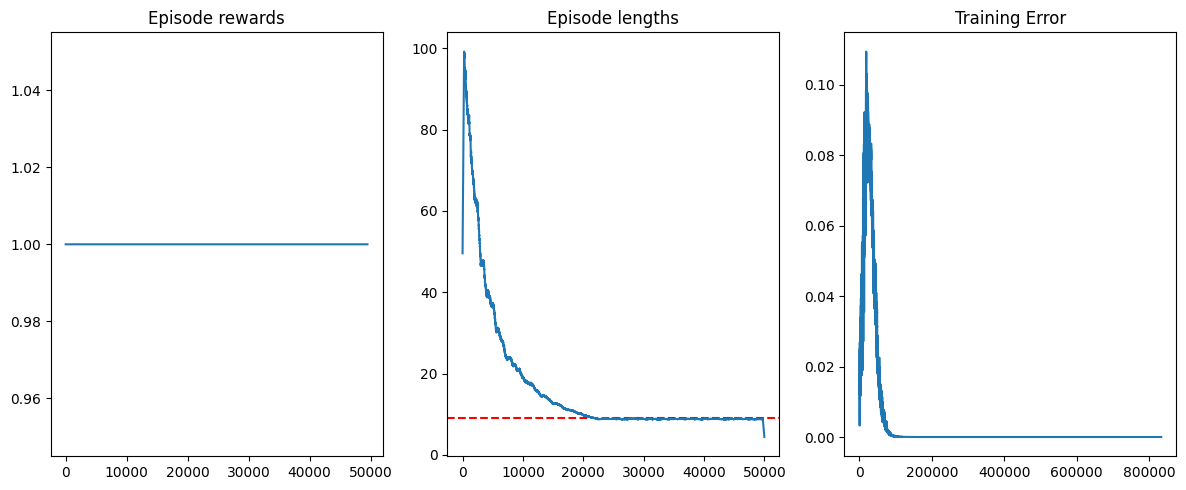

In [9]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (np.convolve(np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

# Add a red line at y = 9 to the right plot
axs[1].axhline(y=9, color='red', linestyle='--', label='y = 9')

axs[1].set_title("Episode lengths")
length_moving_average = (np.convolve(np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same") / rolling_length)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = (np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

## Visualising the policy



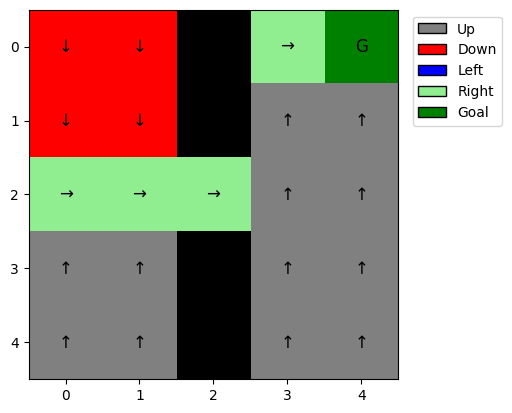

In [10]:
# state values & policy with usable ace (ace counts as 11)
state_value_dict, policy_dict = create_dicts_Qlearning(agent)
value_grid, policy_grid, string_policy_grid = create_grids(state_value_dict, policy_dict, env)
fig = plot_string_policy(string_policy_grid)

plt.show()